In [14]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: April 26, 2018
%matplotlib notebook

import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import pydensecrf.densecrf as dcrf
import cv2
import glob, os
from collections import Counter

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from collections import Counter
import logging
import yaml
import json
from PIL import Image as pil_image
from osgeo import gdal, ogr, osr

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import loadcoraldata_utils as coralutils
import keras
import keras.backend as K
from keras.models import Model, Sequential, load_model
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import img_to_array
from keras.callbacks import Callback
from keras.utils.np_utils import to_categorical
from NeMO_models import FCN
from NeMO_losses import charbonnierLoss
import NeMO_layers
import NeMO_encoders
from NeMO_generator import NeMOImageGenerator, ImageSetLoader
from NeMO_callbacks import CheckNumericsOps, WeightsSaver

num_cores = 4
num_GPU = 1
num_CPU = 1

global _SESSION
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
_SESSION = tf.Session(config=config)
K.set_session(_SESSION)

%matplotlib notebook

model = load_model('./tmp/RefineMask_Jarrett256_RGB_NIR3.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 4)   0                                            
____________________________________________________________________________________________________
vgg_convblock1_conv1 (Conv2D)    (None, 128, 128, 64)  12608       input_1[0][0]                    
____________________________________________________________________________________________________
vgg_convblock1_BatchNorm1 (Batch (None, 128, 128, 64)  256         vgg_convblock1_conv1[0][0]       
____________________________________________________________________________________________________
vgg_convblock1_Activ1 (Activatio (None, 128, 128, 64)  0           vgg_convblock1_BatchNorm1[0][0]  
___________________________________________________________________________________________

In [3]:
# Test export of patches from gdal
imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_001.TIF'
imgpath_original = '/home/shared/NeMO-Net Data/KSLOF-CICIA-FIJI/Cicia_Satellite_image_mosaic_KSLOF.tif'
truthpath = '/home/shared/NeMO-Net Data/KSLOF-CICIA-FIJI/Cicia_Habitat_classes_raster_KSLOF.tif'
imgpath2 = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_002.TIF'

output_trainpath = '../Images/Fiji_Training_Patches/'
output_trainrefpath = '../Images/Fiji_TrainingRef_Patches/'
output_trainfilename = 'rastertrain.txt'
output_validpath = '../Images/Fiji_Valid_Patches/'
output_validrefpath = '../Images/Fiji_ValidRef_Patches/'
output_validfilename = 'rastervalid.txt'
jsonpath = './utils/CoralClasses.json'

with open(jsonpath) as json_file:
    json_data = json.load(json_file)

Fiji = coralutils.CoralData(imgpath, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")
Fiji.Consolidate_classes(newclassdict=json_data["L3_ClassDict"], transferdict=json_data["Fiji2L3_Dict"])
FijiTruth_24classes = np.copy(Fiji.truthimage_consolidated)
Fiji.Consolidate_classes(newclassdict=json_data["VedConsolidated_ClassDict"], transferdict=json_data["L32VedConsolidated_Dict"])
FijiTruth_Ved = np.copy(Fiji.truthimage_consolidated)

Fiji2 = coralutils.CoralData(imgpath2, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")
Fiji2.Consolidate_classes(newclassdict=json_data["L3_ClassDict"], transferdict=json_data["Fiji2L3_Dict"])
Fiji2.Consolidate_classes(newclassdict=json_data["MajorConsolidated_ClassDict"], transferdict=json_data["L32MajorConsolidated_Dict"])
FijiTruth_Major = np.copy(Fiji2.truthimage_consolidated)

labelkey = json_data["VedConsolidated_ClassDict"]
class_indices_rev_Ved = dict((v,k) for k,v in labelkey.items()) #flip k,v
labelkey_24classes = json_data["L3_ClassDict"]
class_indices_rev_24classes = dict((v,k) for k,v in labelkey_24classes.items()) #flip k,v

with open("init_args - Jarrett.yml", 'r') as stream:
    try:
        init_args = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

train_loader = ImageSetLoader(**init_args['image_set_loader']['train'])
val_loader = ImageSetLoader(**init_args['image_set_loader']['val'])

num_channels = 4
y = train_loader.target_size[1]
x = train_loader.target_size[0]

pixel_mean = 100*np.ones(num_channels)
pixel_std = 100*np.ones(num_channels)


./utils/loadcoraldata_utils.py:223: RuntimeWarning: divide by zero encountered in long_scalars
  self.consolclass_weights = dict((k, (self.truthimage_consolidated.shape[0]*self.truthimage_consolidated.shape[1])/(self.truthimage_consolidated==newclassdict[k]).sum()) for k in newclassdict)


<IPython.core.display.Javascript object>


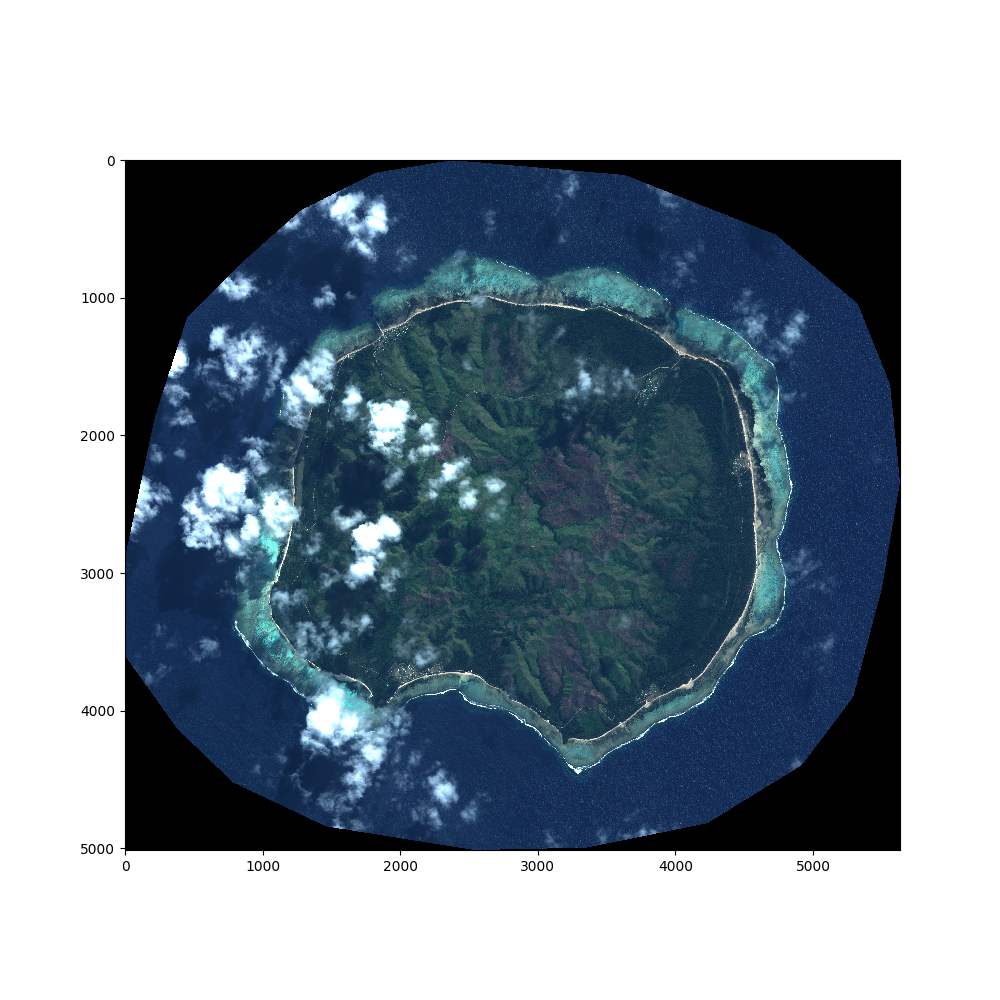

<IPython.core.display.Javascript object>


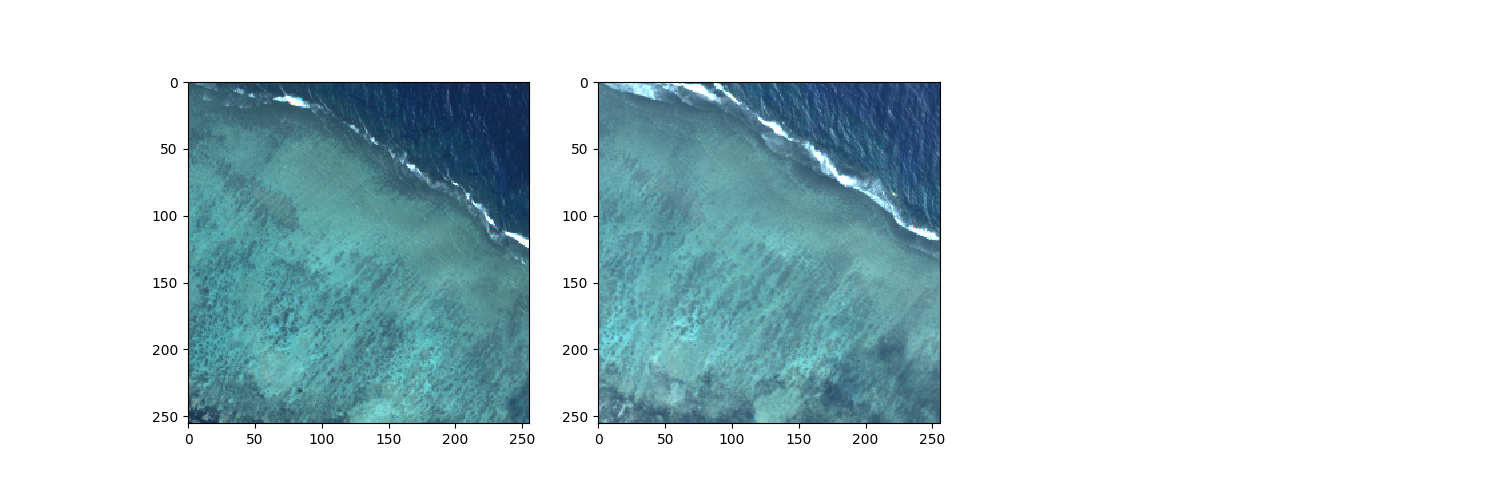

In [5]:
cmap_24classes = colors.ListedColormap(['xkcd:black', '#ae729b', '#7d3fba', '#8f7ab4', '#51528c',
                             '#846a99', 'xkcd:pink', '#d83f3f', '#f140a0', '#ec684e', '#ff8181',
                             '#161616', 'xkcd:dark blue', '#f8f8f8', 'xkcd:grey', '#2ca4ab',
                             'xkcd:forest', '#189d60', '#916d9e', 'xkcd:tan',
                             '#d35583', 'xkcd:olive', 'xkcd:blue', 'xkcd:orange'])
bounds_24classes = [i+0.5 for i in range(25)]
norm_24classes = colors.BoundaryNorm([b+0.5 for b in bounds_24classes], cmap_24classes.N)

cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
bounds = [i+0.5 for i in range(10)]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_Ved.N)

# xstart = 4100
xstart = 3500
xlen = 256
ystart = 800
# ystart = 2900
ylen = 256

predict_size = 128

Fiji.testimage = Fiji.image[ystart:ystart+ylen,xstart:xstart+xlen,:]
Fiji.testimage = np.delete(Fiji.testimage, [0,3,5,7], 2) # harded coded for BGR + NIR
Fiji2.testimage = Fiji2.image[ystart:ystart+ylen,xstart:xstart+xlen,:]
Fiji2.testimage = np.delete(Fiji2.testimage, [0,3,5,7], 2) # harded coded for BGR + NIR

patch_R = 255/200*Fiji.image[:,:,4]
patch_G = 255/200*Fiji.image[:,:,2]
patch_B = 255/200*Fiji.image[:,:,1]
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255
Fiji_RGB = np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3)
# Fiji_RGB = np.rollaxis(np.asarray([1/max_R*Fiji.image[:,:,2], 1/max_G*Fiji.image[:,:,1], 1/max_B*Fiji.image[:,:,0]]),0,3)
# print(np.unique(Testtruth))

fig = plt.figure(1,figsize=(10,10))
plt.imshow(Fiji_RGB)

{1: 'Coral', 2: 'Sediment', 3: 'Beach', 4: 'Seagrass', 5: 'Terrestrial vegetation', 6: 'Deep water', 7: 'Clouds', 8: 'Wave breaking', 9: 'Other or Unknown'}
Line: 0 Col: 0/ 1 completed


<IPython.core.display.Javascript object>


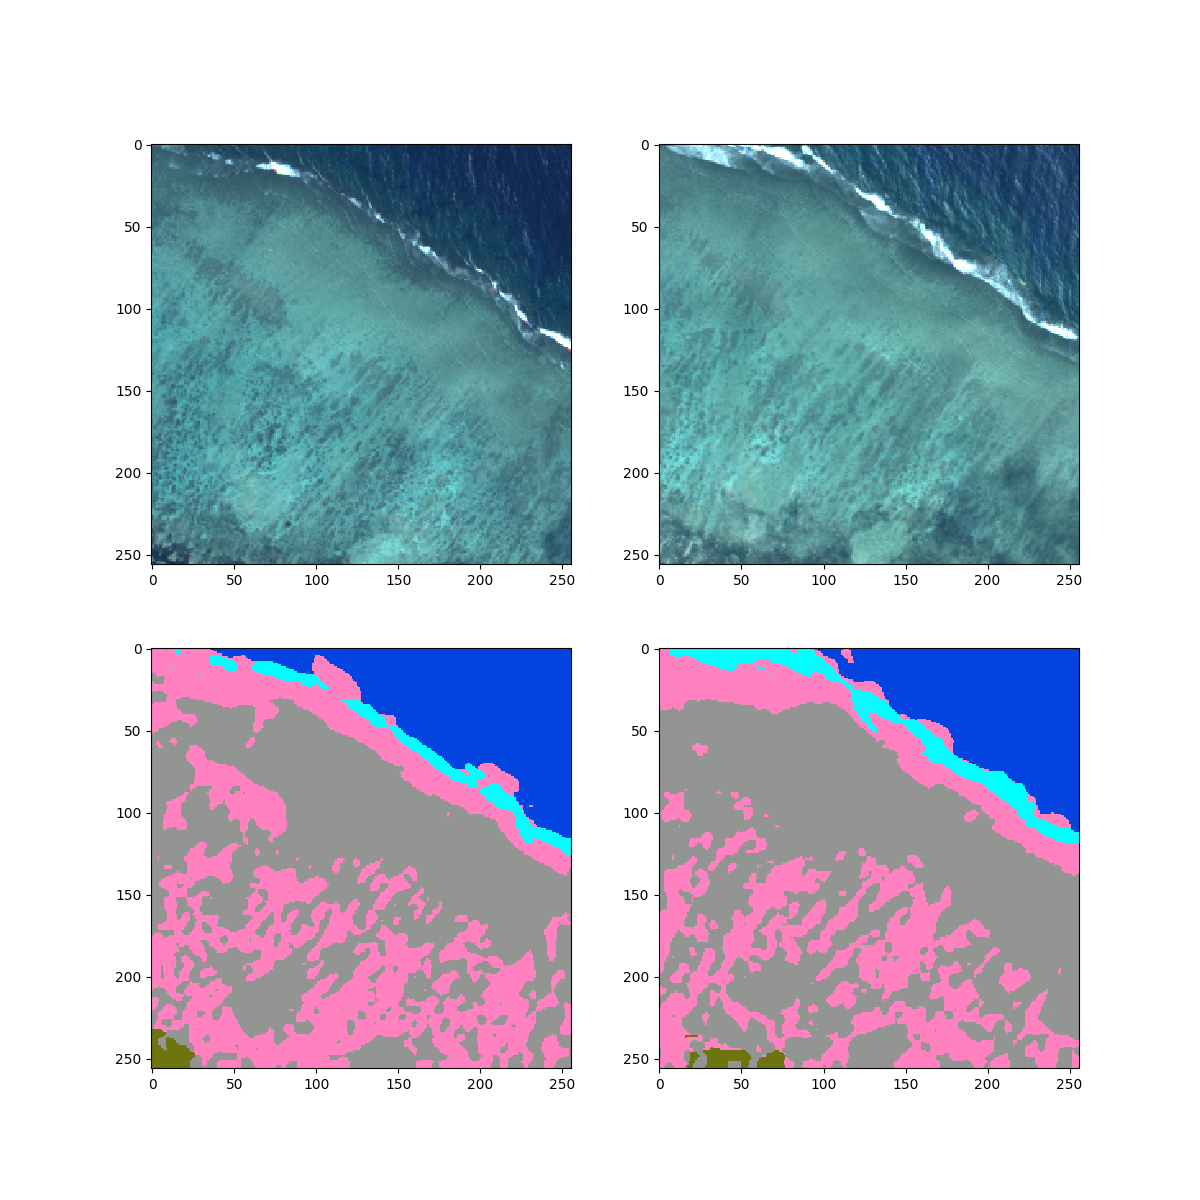

Line: 0 Col: 0/ 1 completed


In [33]:

class_indices_rev = dict((v,k) for k,v in labelkey.items()) #flip k,v
print(class_indices_rev)

Fiji.set_mean_std(100,100)
whole_predict, num_predict, prob_predict, truth_predict, accuracy = \
    Fiji.predict_on_whole_image(model, image_size = 256, num_classes = len(class_indices_rev), spacing = (256,256), predict_size = 256, num_lines=None, lastchannelremove=False)

fig = plt.figure(10,figsize=(12,12))

ax = plt.subplot(221)
ax.imshow(Fiji_RGB[ystart:ystart+ylen,xstart:xstart+xlen,:])

patch_R = 255/200*(Fiji2.testimage[:,:,2])
patch_G = 255/200*(Fiji2.testimage[:,:,1])
patch_B = 255/200*(Fiji2.testimage[:,:,0])
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255
ax = plt.subplot(222)
ax.imshow(np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3))
# Fiji2.testimage[:,:,0] = Fiji2.testimage[:,:,0]
# Fiji2.testimage[:,:,1] = Fiji2.testimage[:,:,1]
# Fiji2.testimage[:,:,2] = Fiji2.testimage[:,:,2]
# Fiji2.testimage[:,:,3] = Fiji2.testimage[:,:,3]


ax = plt.subplot(223)
ax.imshow(whole_predict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
plt.show()

Fiji2.set_mean_std(100,100)
whole_predict, num_predict, prob_predict, truth_predict, accuracy = \
    Fiji2.predict_on_whole_image(model, image_size = 256, num_classes = len(class_indices_rev), spacing = (256,256), predict_size = 256, num_lines=None, lastchannelremove=False)

ax = plt.subplot(224)
ax.imshow(whole_predict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
plt.show()

In [41]:
layer_name = 'vgg_convblock1_conv1'
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
intermediate_output1 = intermediate_layer_model.predict(np.expand_dims(Fiji.testimage,axis=0))
intermediate_output2 = intermediate_layer_model.predict(np.expand_dims(Fiji2.testimage,axis=0))

for i in range(1,2):
    s1 = intermediate_output1[0,:,:,i]*np.transpose(intermediate_output1[0,:,:,i])
    s2 = intermediate_output2[0,:,:,i]*np.transpose(intermediate_output2[0,:,:,i])

print(s1)
print(s2)


[[ 3.9361858e+01 -5.4652728e+02 -4.9939951e+02 ... -2.0313556e+02
   1.3761626e+02  4.6794125e+01]
 [-5.4652728e+02  4.6434925e+01 -1.0486060e+00 ...  3.7613289e+00
   7.6243217e+01  4.1650398e+01]
 [-4.9939951e+02 -1.0486060e+00  2.9446435e+00 ...  1.1534670e-02
   1.7244916e+02  7.9920707e+00]
 ...
 [-2.0313556e+02  3.7613289e+00  1.1534670e-02 ...  1.9617218e+01
   9.0453773e+01 -2.6410282e+01]
 [ 1.3761626e+02  7.6243217e+01  1.7244916e+02 ...  9.0453773e+01
   6.1181677e+02  2.1444968e+02]
 [ 4.6794125e+01  4.1650398e+01  7.9920707e+00 ... -2.6410282e+01
   2.1444968e+02  1.3999560e+00]]
[[ 1.6866609e+02 -7.7446283e+02 -8.3108771e+02 ... -2.8361761e+02
   3.8055258e+02  8.2991440e+01]
 [-7.7446283e+02  2.2946978e+01 -3.9708521e+00 ... -7.0315762e+00
  -4.2708866e+01 -1.0118903e+01]
 [-8.3108771e+02 -3.9708521e+00  3.2441624e-04 ... -2.6265936e+01
   1.9105939e+02 -1.7587093e+01]
 ...
 [-2.8361761e+02 -7.0315762e+00 -2.6265936e+01 ...  2.6859215e-04
   1.4137770e+02  5.0197482e+00]

<IPython.core.display.Javascript object>


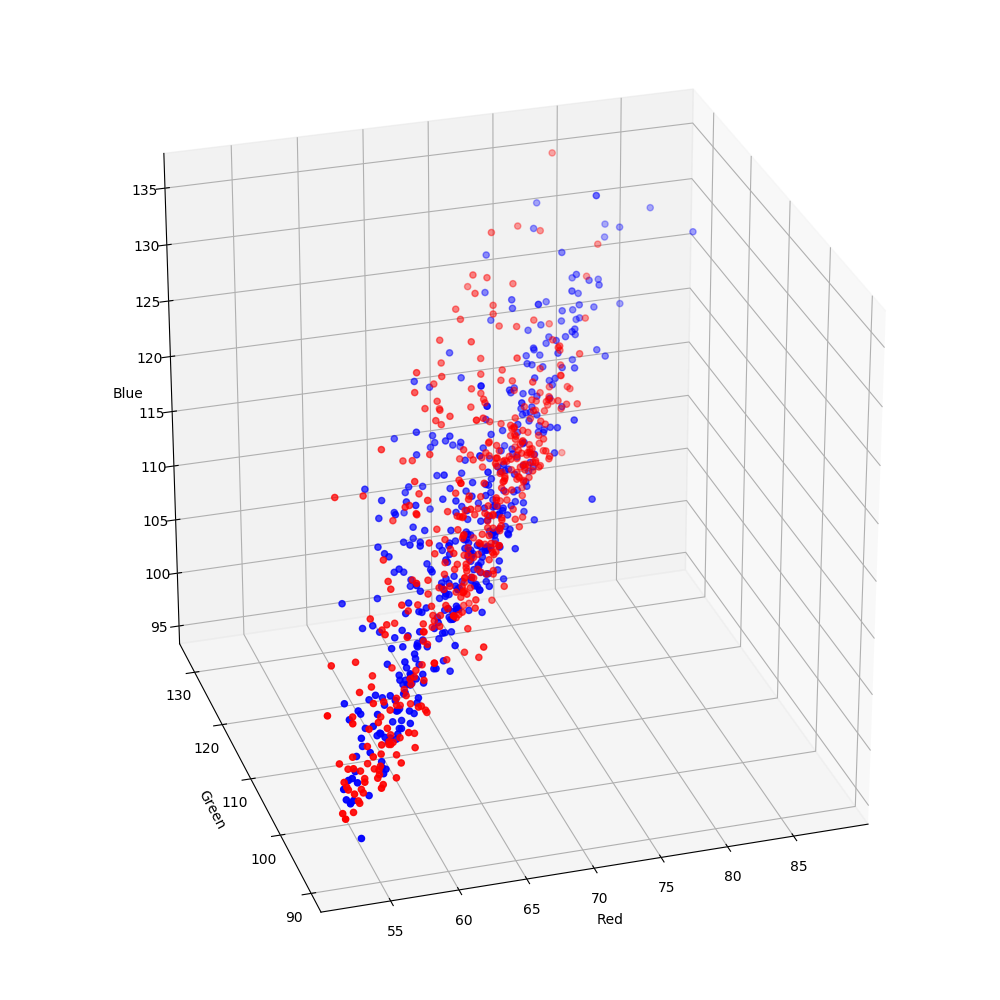

13.32630532026291 66.28695336341858 109.24457208633423 113.45230365753174
13.776049945354462 66.46932498931885 109.85707090377808 113.10174255371093


In [30]:
from mpl_toolkits.mplot3d import Axes3D

# sg_ystart = 520
# sg_xstart = 131
# sg_ylen = 20
# sg_xlen = 20

# sed_ystart = 80
# sed_xstart = 180
# sed_ylen = 20
# sed_xlen = 20

# veg_ystart = 0
# veg_xstart = 204
# veg_ylen = 20
# veg_xlen = 20

# ocn_ystart = 230
# ocn_xstart = 14
# ocn_ylen = 20
# ocn_xlen = 20

coral_ystart = 83
coral_xstart = 52
coral_ylen = 20
coral_xlen = 20

# ystart1 = 455
# ylen1 = 200
# xstart1 = 300
# xlen1 = 200

# sample_sg_pts1 = Testimage1[sg_ystart:sg_ystart+sg_ylen,sg_xstart:sg_xstart+sg_xlen,:]
# sample_sg_pts2 = Testimage2[sg_ystart:sg_ystart+sg_ylen,sg_xstart:sg_xstart+sg_xlen,:]
# sample_sg_pts3 = Testimage3[sg_ystart:sg_ystart+sg_ylen,sg_xstart:sg_xstart+sg_xlen,:]
# sample_sed_pts1 = Testimage1[sed_ystart:sed_ystart+sed_ylen,sed_xstart:sed_xstart+sed_xlen,:]
# sample_sed_pts2 = Testimage2[sed_ystart:sed_ystart+sed_ylen,sed_xstart:sed_xstart+sed_xlen,:]
# sample_sed_pts3 = Testimage3[sed_ystart:sed_ystart+sed_ylen,sed_xstart:sed_xstart+sed_xlen,:]
# sample_veg_pts1 = Testimage1[veg_ystart:veg_ystart+veg_ylen,veg_xstart:veg_xstart+veg_xlen,:]
# sample_veg_pts2 = Testimage2[veg_ystart:veg_ystart+veg_ylen,veg_xstart:veg_xstart+veg_xlen,:]
# sample_veg_pts3 = Testimage3[veg_ystart:veg_ystart+veg_ylen,veg_xstart:veg_xstart+veg_xlen,:]
# sample_ocn_pts1 = Testimage1[ocn_ystart:ocn_ystart+ocn_ylen,ocn_xstart:ocn_xstart+ocn_xlen,:]
# sample_ocn_pts2 = Testimage2[ocn_ystart:ocn_ystart+ocn_ylen,ocn_xstart:ocn_xstart+ocn_xlen,:]
# sample_ocn_pts3 = Testimage3[ocn_ystart:ocn_ystart+ocn_ylen,ocn_xstart:ocn_xstart+ocn_xlen,:]
sample_coral_pts1 = Fiji.testimage[coral_ystart:coral_ystart+coral_ylen,coral_xstart:coral_xstart+coral_xlen,:]
sample_coral_pts2 = Fiji2.testimage[coral_ystart:coral_ystart+coral_ylen,coral_xstart:coral_xstart+coral_xlen,:]
# sample_coral_pts3 = Testimage3[coral_ystart:coral_ystart+coral_ylen,coral_xstart:coral_xstart+coral_xlen,:]

fig = plt.figure(4,figsize=(10,10))
ax = Axes3D(fig)
# edge_numstart = 10000
# edge_numend = 20000
# ax.scatter(edge_pts1[:,4], edge_pts1[:,2], edge_pts1[:,1], c='r')
# ax.scatter(edge_pts3[:,4], edge_pts3[:,2]-9, edge_pts3[:,1]-8, c='g')

# print(np.median(edge_pts1[:,:], axis=0))
# print(np.median(edge_pts3[:,:], axis=0))

# ax.scatter(sample_sg_pts1[:,:,4].flatten(), sample_sg_pts1[:,:,2].flatten(), sample_sg_pts1[:,:,1].flatten(), c='r', marker='o')
# ax.scatter(sample_sg_pts2[:,:,4].flatten(), sample_sg_pts2[:,:,2].flatten(), sample_sg_pts2[:,:,1].flatten(), c='b', marker='o')
# ax.scatter(sample_sg_pts3[:,:,4].flatten(), sample_sg_pts3[:,:,2].flatten(), sample_sg_pts3[:,:,1].flatten(), c='g', marker='o')

# ax.scatter(sample_sed_pts1[:,:,4].flatten(), sample_sed_pts1[:,:,2].flatten(), sample_sed_pts1[:,:,1].flatten(), c='r', marker='x')
# ax.scatter(sample_sed_pts2[:,:,4].flatten(), sample_sed_pts2[:,:,2].flatten(), sample_sed_pts2[:,:,1].flatten(), c='b', marker='x')
# ax.scatter(sample_sed_pts3[:,:,4].flatten(), sample_sed_pts3[:,:,2].flatten(), sample_sed_pts3[:,:,1].flatten(), c='g', marker='x')

ax.scatter(sample_coral_pts1[:,:,2].flatten(), sample_coral_pts1[:,:,1].flatten(), sample_coral_pts1[:,:,0].flatten(), c='r', marker='o')
ax.scatter(sample_coral_pts2[:,:,2].flatten(), sample_coral_pts2[:,:,1].flatten(), sample_coral_pts2[:,:,0].flatten(), c='b', marker='o')
# ax.scatter(sample_coral_pts3[:,:,4].flatten(), sample_coral_pts3[:,:,2].flatten(), sample_coral_pts3[:,:,1].flatten(), c='g', marker='o')

# print(np.median(np.reshape(sample_sg_pts1, (-1,8)), axis=0))
# print(np.median(np.reshape(sample_sg_pts3, (-1,8)), axis=0))

# ax.scatter(sample_veg_pts1[:,:,4].flatten(), sample_veg_pts1[:,:,2].flatten(), sample_veg_pts1[:,:,1].flatten(), c='r', marker='^')
# ax.scatter(sample_veg_pts2[:,:,4].flatten(), sample_veg_pts2[:,:,2].flatten(), sample_veg_pts2[:,:,1].flatten(), c='b', marker='^')
# ax.scatter(sample_veg_pts3[:,:,4].flatten(), sample_veg_pts3[:,:,2].flatten(), sample_veg_pts3[:,:,1].flatten(), c='g', marker='^')

# ax.scatter(sample_ocn_pts1[:,:,4].flatten(), sample_ocn_pts1[:,:,2].flatten(), sample_ocn_pts1[:,:,1].flatten(), c='r', marker='P')
# ax.scatter(sample_ocn_pts2[:,:,4].flatten(), sample_ocn_pts2[:,:,2].flatten(), sample_ocn_pts2[:,:,1].flatten(), c='b', marker='P')
# ax.scatter(sample_ocn_pts3[:,:,4].flatten(), sample_ocn_pts3[:,:,2].flatten(), sample_ocn_pts3[:,:,1].flatten(), c='g', marker='P')


ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
plt.show()

print(np.mean(sample_coral_pts1[:,:,3]), np.mean(sample_coral_pts1[:,:,2]), np.mean(sample_coral_pts1[:,:,1]), np.mean(sample_coral_pts1[:,:,0]))
print(np.mean(sample_coral_pts2[:,:,3]), np.mean(sample_coral_pts2[:,:,2]), np.mean(sample_coral_pts2[:,:,1]), np.mean(sample_coral_pts2[:,:,0]))
                                  